In [12]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import numpy as np
import scipy.spatial
import pandas as pd
import sklearn.decomposition
import matplotlib.pyplot as plt
# import keras
from sklearn import preprocessing
from sklearn.metrics import pairwise_distances,mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
import sys
sys.path.insert(0, '../utils/') 
from readProfiles import *
from pred_models import *
from saveAsNewSheetToExistingFile import saveAsNewSheetToExistingFile
from multiprocessing import Pool

sns.set_style("whitegrid")
# from utils import networksEvol, tsne, readProfiles
# import umap

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


#### Paths

In [ ]:
# procProf_dir='/home/ubuntu/datasetsbucket/Rosetta-GE-CP/'
# procProf_dir='/home/ubuntu/bucket/projects/2018_04_20_Rosetta/workspace/'
# metadata_dir='/home/ubuntu/bucket/projects/2018_04_20_Rosetta/workspace/metadata/'
results_dir='../results/'
source_data_add='../results/Figs_Source_Data.xlsx'

In [ ]:
pd.read_excel(source_data_add, sheet_name=None).keys()

## Read single gene prediction results

In [8]:
# filename=results_dir+'/SingleGenePred/scores_checkIfitisfixedRandomSeed.xlsx'
filename=results_dir+'/SingleGenePred/scores_corrected.xlsx'
saved_scores=pd.read_excel(filename, sheet_name=None)
saved_scores.keys()

dict_keys(['MLP-LUAD-nvs-filt-9-ht', 'Lasso-LUAD-nvs-filt-9-ht', 'MLP-TAORF-nvs--5-ht', 'Lasso-TAORF-nvs--5-ht', 'MLP-LINCS-nvs-filt-25-ht', 'Lasso-LINCS-nvs-filt-25-ht', 'MLP-CDRP-bio-nvs-filt-6-ht', 'Lasso-CDRP-bio-nvs-filt-6-ht'])

In [ ]:
# filename=results_dir+'/SingleGenePred/scores_hyperParam.xlsx'
filename=results_dir+'/SingleGenePred/scores_corrected.xlsx'
saved_scores=pd.read_excel(filename, sheet_name=None)
saved_scores.keys()

################################################
# dataset options: 'CDRP' , 'LUAD', 'TAORF', 'LINCS', 'CDRP-bio'
datasets=['LUAD', 'TAORF', 'LINCS', 'CDRP-bio'];
# datasets=['LUAD', 'TAORF', 'LINCS', 'CDRP-bio','CDRP'];

DT_kfold={'LUAD':9, 'TAORF':5, 'LINCS':25, 'CDRP-bio':6,'CDRP':40}
# DT_kfold={'LUAD':10, 'TAORF':10, 'LINCS':25, 'CDRP-bio':10,'CDRP':40}

################################################
# CP Profile Type options: 'augmented' , 'normalized', 'normalized_variable_selected'
profileType='normalized_variable_selected'
profTypeAbbrev=''.join([s[0] for s in profileType.split('_')])

################################################
# filtering to compounds which have high replicates for both GE and CP datasets
highRepOverlapEnabled=1


################################################
pertColName='PERT'
profileLevel='treatment'; #'replicate'  or  'treatment'
if highRepOverlapEnabled:
    f='filt'
else:
    f=''
    
models=["MLP","Lasso"]

# DataPredResults=pd.DataFrame(columns=["Dataset","Model"])
DataPredResults_ls=[]

fig, axes = plt.subplots(len(datasets),len(models),figsize=(4*len(models),3*len(datasets)))
sns.set_context("paper")
sns.set_style("whitegrid")
# sns.rcParams['patch.force_edgecolor'] = True
# for d in range(5):#(len(datasets)):
df_q=pd.read_excel('../idmap.xlsx') 
for d in range(len(datasets)):
    for m in range(len(models)):
                              
        if datasets[d]=='TAORF' or datasets[d]=='CDRP':     
            f=''
        else:
            f='filt'            

        k_fold=DT_kfold[datasets[d]] 
        sheetName=models[m]+'-'+datasets[d]+'-'+profTypeAbbrev+'-'+f+'-'+str(k_fold)+'-ht'

        res_sheet=saved_scores[sheetName]
#         res_sheet_2save=res_sheet.merge(df_q, left_on='lmGens', right_on='gene',how='left')\
#         [['lmGens', 'pred score', 'd', 'probe_id', 'query','symbol','gene']]
#         saveAsNewSheetToExistingFile(filename2,res_sheet_2save,sheetName)
#         d_to_pl=res_sheet.reset_index().copy()
        d_to_pl=res_sheet.groupby(['symbol','d']).median().reset_index()   
        d_to_pl_2=d_to_pl.copy()
        
#         d_to_pl_2=res_sheet.copy()
#         print('d',len(set(d_to_pl['lmGens'].unique().tolist()) & set(df_q['gene'].unique().tolist())))
        d_to_pl_2['Dataset']=datasets[d]
        d_to_pl_2['Model']=models[m]
        
        
        
        # axes=sns.displot(data=d_to_pl, x="pred score", hue="d")
        #     sns.distplot(saved_scores['Lasso-'+datasets[d]+filter_status[d]].pred_score.values,kde=True,hist=True,bins=100,label=datasets[d],ax=axes,norm_hist=True);
        pred_scoress=d_to_pl[d_to_pl["d"]=="n-folds"]["pred score"].values
#         pred_scoress=res_sheet[res_sheet['d']=='n-folds']["pred score"].values
        rand_scoress=d_to_pl[d_to_pl["d"]=="random"]["pred score"].values
#         rand_scoress=res_sheet[res_sheet['d']=='random']["pred score"].values
        sns.distplot(pred_scoress,kde=True,hist=True,bins=100,label=datasets[d],ax=axes[d,m],norm_hist=True,color='r')
        sns.distplot(rand_scoress,kde=True,hist=True,bins=100,label='random',ax=axes[d,m],norm_hist=True)
        rand99th=np.percentile(rand_scoress,99)
        print(rand99th)
        
        d_to_pl_2['rand99th']=rand99th
        DataPredResults_ls.append(d_to_pl_2)
        
        
        axes[d,0].set_xlim(-1,1)
        axes[d,1].set_xlim(-1,1)
#         axes[d,1].set_xlim(-.5,.5)
#         axes[d,m].set_xlim(-0.5,0.6)
#         axes[d,m].set_ylim(0,15)
        axes[d,m].axvline(x=np.percentile(rand_scoress,90),linestyle=':',color='r');
        axes[len(datasets)-1,m].set_xlabel("Accuracy ($R^2$)");
        axes[d,m].legend();
        axes[0,m].set_title(models[m]);

DataPredResults=pd.concat(DataPredResults_ls, ignore_index=True)        
        
DataPredResults.loc[DataPredResults['d']=='random','Model']=DataPredResults[DataPredResults['d']=='random']['Model']+'-'+DataPredResults[DataPredResults['d']=='random']['d']

In [ ]:
res_sheet

## Single gene prediction barplot for each dataset and each model
- Figeure 2a

In [ ]:
# DataPredResults.groupby(['Dataset','Model','d']).size()
# DataPredResults
%matplotlib notebook
import matplotlib.style as style
style.use('seaborn-colorblind')
sns.set_context("paper",font_scale = 2, rc={"font.size":20,"axes.titlesize":8,"axes.labelsize":10})

# DataPredResults.loc[DataPredResults['d']=='random','Model']=DataPredResults[DataPredResults['d']=='random']['Model']+'-'+DataPredResults[DataPredResults['d']=='random']['d']
plt.figure(figsize=(13,4))

# plt.rcParams["axes.labelsize"] = 40
sns.set_theme(style="whitegrid")
ax = sns.boxplot(x="Dataset", y="pred score", hue="Model",data=DataPredResults,\
                order=['TAORF','CDRP-bio','LINCS','LUAD'], hue_order=['Lasso-random','Lasso','MLP-random','MLP'])
ax.set_ylim(-0.5,1);
ax.set_ylabel("Accuracy ($R^2$)", fontweight='bold'); #fontsize=14,
ax.axhline(y=0,linestyle=':',color='k');
plt.tight_layout()
plt.legend(bbox_to_anchor=(1, .65), loc='upper left', borderaxespad=0)
plt.tight_layout()

if 0:
    plt.savefig('fig2a.pdf')
    saveAsNewSheetToExistingFile(source_data_add,DataPredResults,'fig2a')

#### Save derived list of genes for GO analysis

In [ ]:
# meta=pd.read_csv("/home/ubuntu/bucket/projects/2018_04_20_Rosetta/workspace/metadata/affy_probe_gene_mapping.txt",delimiter="\t",header=None, names=["probe_id", "gene"])
# meta
#         meta_gene_probID=meta.set_index('probe_id')
#         d = dict(zip(meta_gene_probID.index, meta_gene_probID['gene']))
union_geneSymbols_1170=DataPredResults.symbol.unique()
# len(union_geneSymbols_1170)

textfile = open("../GO_terms_search/union_geneSymbols_1170.txt", "w")
for element in union_geneSymbols_1170:
    textfile.write(element + "\n")
textfile.close()

ov_c=DataPredResults[(DataPredResults['d']=='n-folds')].groupby(['symbol']).size()==8
overlap_genes_across_DSs=ov_c[ov_c==True].index.tolist()
textfile = open("../GO_terms_search/intersection_geneSymbols_785.txt", "w")
for element in overlap_genes_across_DSs:
    textfile.write(element + "\n")
textfile.close()

LUAD_978=DataPredResults[(DataPredResults['Dataset']=='LUAD')].symbol.unique().tolist()
textfile = open("../GO_terms_search/LUAD_geneSymbols_978.txt", "w")
for element in LUAD_978:
    textfile.write(element + "\n")
textfile.close()

## Single gene prediction table
- Figure 2b

In [ ]:
DataPredResults2=DataPredResults.loc[DataPredResults['d']!='random'].reset_index(drop=True)
DataPredResults2[DataPredResults2["pred score"]>DataPredResults2['rand99th']+0.2].\
groupby(['Dataset','Model']).size()*100/978#*100/977

In [ ]:
DataPredResults2=DataPredResults.loc[DataPredResults['d']!='random'].reset_index(drop=True)
DataPredResults2[DataPredResults2["pred score"]>DataPredResults2['rand99th']+0.2].groupby(['Dataset','Model']).size()

In [ ]:
if 0:
    saveAsNewSheetToExistingFile(source_data_add,(DataPredResults2[DataPredResults2["pred score"]>DataPredResults2['rand99th']+0.2].groupby(['Dataset','Model']).size()),'fig2b')

## Venn diagram of the highly predictable genes across datasets - MLP model
- Figure 2c

In [ ]:
DataPredRes4venn=DataPredResults2[DataPredResults2["pred score"]>DataPredResults2['rand99th']+0.2]
DataPredRes4venn=DataPredRes4venn[DataPredRes4venn['Model']=='MLP'].reset_index(drop=True)
DataPredRes4venn['hp-scores']=DataPredRes4venn["pred score"]-(DataPredRes4venn['rand99th']+0.2)
# DataPredRes4venn

from venn import venn
list_4_ven={}
dsets=["CDRP-bio","LINCS","LUAD", "TAORF"]
set_lab=tuple(dsets) 
# plt.figure()
for d in dsets:
    list_4_ven[d]=set(DataPredRes4venn[DataPredRes4venn["Dataset"]==d].symbol)

# venn(list_4_ven,legend_loc='upper center')
venn(list_4_ven,legend_loc='lower right');
# plt.tight_layout()
# plt.savefig('fig2c.pdf')
if 0:
    saveAsNewSheetToExistingFile(source_data_add,DataPredRes4venn[['symbol','Dataset','Model']],'fig2c')

In [ ]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    print(DataPredRes4venn.groupby('symbol').size().reset_index())

In [ ]:
# DataPredRes4venn

In [ ]:

# top_58_overlappingGenes=DataPredRes4venn.groupby('symbol').size()[list(DataPredRes4venn.groupby('symbol').size()>3)].index.to_list()

# textfile = open("top_58_common.txt", "w")
# for element in top_58_overlappingGenes:
#     textfile.write(element + "\n")
# textfile.close()

In [ ]:
np.sum([list(DataPredRes4venn.groupby('symbol').size()>2)])

In [ ]:
# DataPredRes4venn.groupby('symbol').size()

In [ ]:
## Save for GO analysis
top_59_atleast_topIn3=DataPredRes4venn.groupby('symbol').size()[list(DataPredRes4venn.groupby('symbol').size()>2)].index.to_list()
len(top_59_atleast_topIn3)
textfile = open("../GO_terms_search/top_59_atleast_topIn3.txt", "w")
for element in top_59_atleast_topIn3:
    textfile.write(element + "\n")
textfile.close()

## Explore gene family of top 100 genes in LUAD
- Using hgnc_gene_group_family_dictionary

- Extended data 2

In [ ]:
# top 58 overlap in all datasets
"""
topInAll=DataPredRes4venn.groupby(['lmGens','Dataset']).size().reset_index().groupby(['lmGens']).size().reset_index()
top58=topInAll[topInAll[0]>3].lmGens.tolist()
"""

# top 20 in LUAD - First version
# top58=DataPredResults2[DataPredResults2["Dataset"]=="LUAD"].sort_values(by="pred score")[-20:]['symbol'].tolist()

# Revision version
top_LUAD=DataPredResults[(DataPredResults['Dataset']=='LUAD') & (DataPredResults['Model']=='MLP')].reset_index(drop=True).\
sort_values(by='pred score',ascending=False).reset_index(drop=True)
# top_luad_list=top_LUAD[top_LUAD['pred score']>0.9]['symbol'].tolist()

top_100_luad_list=top_LUAD[0:100].symbol.tolist()
textfile = open("../GO_terms_search/top_100_luad.txt", "w")
for element in top_100_luad_list:
    textfile.write(element + "\n")
textfile.close()

In [ ]:
# len(top_luad_list)
# top_luad_list


In [ ]:
# top58=DataPredResults2[DataPredResults2["Dataset"]=="LUAD"].sort_values(by="pred score")[-20:]['lmGens'].tolist()
# top58
# DataPredResults2[DataPredResults2["Dataset"]=="LUAD"].sort_values(by="pred score")[-20:]

In [ ]:
print('\n'.join(top_LUAD.lmGens))

In [ ]:
print('\n'.join(top_luad_list))

In [ ]:
meta_geneFamily = pd.read_csv("/home/ubuntu/bucket/projects/2018_04_20_Rosetta/workspace/metadata/hgnc_gene_group_family_dictionary.csv")
# genesU = meta_geneFamily.approved_symbol.unique().tolist()
# meta_geneFamilyU=pd.DataFrame(index=range(len(genesU)),columns=["lmGens","gene_group_name"])

meta_geneFamily_top=meta_geneFamily[meta_geneFamily['approved_symbol'].isin(top_100_luad_list)].reset_index(drop=True)
meta_top=meta_geneFamily_top.groupby(['gene_group_name']).size().sort_values(ascending=False).reset_index()

In [ ]:
two_cols_toprint

In [ ]:
# [meta_top.loc[0:43,['gene_group_name','Genes']].reset_index(drop=True),\
#            meta_top.loc[44:,['gene_group_name','Genes']].reset_index(drop=True)]
meta_top

In [ ]:
# meta_top
two_cols_toprint=pd.concat([meta_top.loc[0:43,['gene_group_name','Genes']].reset_index(drop=True),\
           meta_top.loc[44:,['gene_group_name','Genes']].reset_index(drop=True)],\
          axis=1,ignore_index=True)

In [ ]:
saveAsNewSheetToExistingFile(source_data_add,two_cols_toprint,'ExtendedDataTable2')

In [ ]:
print(two_cols_toprint.to_latex(index=False))  

In [ ]:
# meta_geneFamily_top[meta_geneFamily_top['gene_group_name'].isin(meta_top.gene_group_name.tolist())]
# meta_geneFamily_top.groupby(['gene_group_name','approved_symbol']).size().sort_values(by=ascending=False)
# meta_geneFamily_top.groupby(['gene_group_name']).size()
top_groups=meta_top.gene_group_name.tolist()
for t in top_groups:
    meta_top.loc[meta_top['gene_group_name']==t,'Genes']=\
    ','.join(meta_geneFamily_top.loc[meta_geneFamily_top['gene_group_name']==t,'approved_symbol'].tolist())

In [ ]:
# print(meta_top[['gene_group_name','Genes']].to_latex(index=False))  

In [ ]:
# meta_geneFamily[meta_geneFamily['approved_symbol'].isin(top58)].shape
# meta_top
# meta_geneFamily_top
meta_geneFamily_top.groupby(['gene_group_name','approved_symbol']).size()

In [ ]:
# from matplotlib.cm import get_cmap

# name = "tab20"
# cmap = get_cmap(name,10)  # type: matplotlib.colors.ListedColormap
# # colors = 
# cmap.colors
# # len(labels)

In [ ]:
# fig, ax = plt.subplots(figsize=(8, 7), subplot_kw=dict(aspect="equal"))

# labels = meta_geneFamily_top['approved_symbol'].to_list()
# ingredients = meta_geneFamily_top['gene_group_name'].to_list()
# data=np.ones(meta_geneFamily_top['gene_group_name'].shape[0],)


# wedges, autotexts = ax.pie(data,labels=labels,colors=get_cmap('tab20',len(labels)).colors ,#autopct=lambda pct: func(pct,meta_geneFamily_top),
#                                   textprops=dict(color="k"))

# ax.legend(wedges, ingredients,
#           title="Gene Family",
#           loc="center left",
#           bbox_to_anchor=(1.05, 0, 0.5, 1))

# plt.setp(autotexts, size=10, weight="bold")

# # ax.set_title("LUAD top genes")
# plt.tight_layout()
# plt.show()

In [ ]:
meta_geneFamily_top['approved_symbol'].shape

In [ ]:
# wedges

## Supp Table of prediction scores for each of the MLP and Lasso models 
- Supplementary D

In [ ]:
unq_lmgenes=DataPredResults2['symbol'].unique()

d_luad=DataPredResults2[DataPredResults2['Dataset']=='LUAD'].reset_index(drop=True)
d_cdrpbio=DataPredResults2[DataPredResults2['Dataset']=='CDRP-bio'].reset_index(drop=True)
d_lincs=DataPredResults2[DataPredResults2['Dataset']=='LINCS'].reset_index(drop=True)
d_taorf=DataPredResults2[DataPredResults2['Dataset']=='TAORF'].reset_index(drop=True)

# unq_lmgenes

In [ ]:
# DataPredResults2

In [ ]:
cols=["CDRP-bio-Lasso","CDRP-bio-MLP",\
        "LUAD-Lasso","LUAD-MLP",\
        "LINCS-Lasso","LINCS-MLP",\
        "TAORF-Lasso","TAORF-MLP"]
DataAppendix=pd.DataFrame(index=unq_lmgenes,columns=cols)

for ds in ['LUAD', 'TAORF', 'LINCS', 'CDRP-bio']:
    for m in ['Lasso','MLP']:
        d_luad=DataPredResults2[DataPredResults2['Dataset']==ds].reset_index(drop=True)
        d_luad2=d_luad[(d_luad["Model"]==m)]
        DataAppendix.loc[d_luad2["symbol"].values,ds+"-"+m]=d_luad2["pred score"].values
DataAppendix[cols]=DataAppendix[cols]*100
DataAppendix[cols]=DataAppendix[cols].astype(float).round(2)

In [ ]:
DataAppendix.to_csv(results_dir+'/SingleGenePred/Appendix_D.csv')

In [ ]:
# DataAppendix

In [ ]:
# DataAppendix#.to_markdown()

In [ ]:
# DataAppendix.loc[unq_lmgenes.tolist()]

In [ ]:
DataAppendix.shape
    
# DataAppendix[unq_lmgenes,"LUAD-MLP"]=d_luad[(d_luad["lmGens"].isin(unq_lmgenes))&(d_luad["Model"]=='MLP')]["pred score"]

In [ ]:
# # d_luad["lmGens"]
# # DataAppendix.loc[d_luad["lmGens"].values]
# for i in range(0,55*20,55):
#     print("\\begin{table}")
#     print(DataAppendix[i:i+55].to_latex(index=True))  
#     print("\end{table}")

In [ ]:
# # DataPredResults
# dataset_meth_dists[DataPredResults['Model']==models[m]]

## Supplementary C - Top 50 GE using MLP
- Supplementary C (Supplementary Figure 2.)

In [ ]:
datasets=['TAORF', 'CDRP-bio' ,'LINCS', 'LUAD']
models=["MLP"]
# f='-filt';#'-filt'
DataPredResults=pd.concat(DataPredResults_ls, ignore_index=True)      
fig, axes = plt.subplots(len(datasets),1,figsize=(12,20))
sns.set_context("paper")
sns.set_style("whitegrid")
my_pal = {"random": "g", "n-folds": "r"}
# sns.rcParams['patch.force_edgecolor'] = True
# for d in range(5):#(len(datasets)):
for d in range(len(datasets)):
    for m in range(len(models)):
        dataset_meth_dists=DataPredResults[(DataPredResults['Dataset']==datasets[d]) &\
                                                    (DataPredResults['Model']==models[m])]
        sorted_gene_mean_scores=dataset_meth_dists[dataset_meth_dists['d']=='n-folds'].groupby(['symbol','d']).median().reset_index().sort_values(by=['pred score'],ascending=False)
        top_lmGenes=sorted_gene_mean_scores['symbol'].tolist()[0:50]
        dataset_meth_dists_top_50=dataset_meth_dists[dataset_meth_dists['symbol'].isin(top_lmGenes)]
        
#         f, axes = plt.subplots(figsize=(15,4))
        axes[d].set_title("Dataset: "+datasets[d])
        sns.boxplot(x="symbol", y="pred score",hue="d", data=dataset_meth_dists_top_50,ax=axes[d],order=top_lmGenes,\
                   palette=my_pal,hue_order=['random','n-folds'])
#         sns.swarmplot(x="symbol", y="pred score",hue="d", data=dataset_meth_dists_top_50,ax=axes[d],order=top_lmGenes,color='0.25')
        # ax = sns.violinplot(x="symbol", y="pred score", hue="d",data=tips2, palette="muted", split=True)
        axes[d].set_xticklabels(axes[d].get_xticklabels(),rotation=90,fontsize=10);
        axes[d].set_ylabel("Accuracy ($R^2$)", fontweight='bold');
        axes[d].set_xlabel("L1000 landmark genes");
        axes[d].set_ylim(-1, 1)
        
fig.tight_layout()
fig.savefig('supp_c.pdf',papertype='letter',dpi=500)

## single GE cross datasets prediction results (LUAD and LINCS)
- Extended Data 1

In [10]:
filename=results_dir+'/SingleGenePred/scores_cross_dts_LU_LI.xlsx'
saved_scores=pd.read_excel(filename, sheet_name=None)
saved_scores.keys()
# saved_scores


dict_keys(['Lasso-n-filt-ht', 'Ridge-nvs-filt-ht', 'Lasso-nvsu-filt-ht', 'MLP-nvsu-filt-ht', 'MLP-n-filt-ht', 'Ridge-n-filt-ht', 'Ridge-nvsu-filt-ht'])

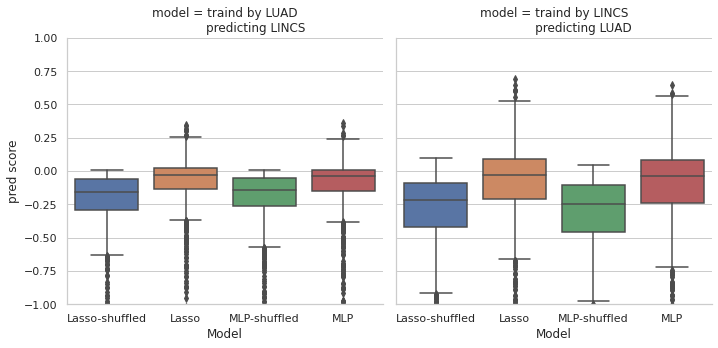

In [11]:
filename=results_dir+'/SingleGenePred/scores_cross_dts_LU_LI.xlsx'
saved_scores=pd.read_excel(filename, sheet_name=None)
saved_scores.keys()

# DataPredResults.loc[DataPredResults['d']=='random','Model']=DataPredResults[DataPredResults['d']=='random']['Model']+'-'+DataPredResults[DataPredResults['d']=='random']['d']

scores_l=saved_scores['Lasso-nvsu-filt-ht']
scores_l['Model']='Lasso'

scores_r=saved_scores['Ridge-nvs-filt-ht']
scores_r['Model']='Ridge'

scores_m=saved_scores['MLP-nvsu-filt-ht']
scores_m['Model']='MLP'

# scores=pd.concat([scores_l,scores_r,scores_m])
scores=pd.concat([scores_l,scores_m])
scores=scores.replace('LUAD-LINCS','traind by LUAD\n                predicting LINCS')
scores=scores.replace('LINCS-LUAD','traind by LINCS\n               predicting LUAD')
scores.loc[scores['d']=='random','Model']=scores[scores['d']=='random']['Model']+'-shuffled'#+scores[scores['d']=='random']['d']
# my_pal = {"random": "g", "n-folds": "r"}
sns.set(font_scale = 1)
sns.set_style("whitegrid")
scores=scores.rename(columns={'DT':'model'})
ax = sns.catplot(x="Model", y="pred score",col="model",kind="box",order=['Lasso-shuffled','Lasso','MLP-shuffled','MLP'],
                 data=scores, linewidth=1.5)
# ax[0].set_title('hello')
# hue_order=['random','n-folds'], palette=my_pal
# ax.set_ylim(-1,1);
ax.set(ylim=(-1, 1))

if 0:
    ax.savefig('exd_1.pdf',papertype='letter',dpi=500)
    saveAsNewSheetToExistingFile(source_data_add,scores,'ExtendedData1')

## Read single CP feature prediction results
- Figure 3a

In [ ]:
filename=results_dir+'/SingleCPfeatPred/scores_corrected.xlsx'
saved_scores=pd.read_excel(filename, sheet_name=None)
saved_scores.keys()

################################################
# dataset options: 'CDRP' , 'LUAD', 'TAORF', 'LINCS', 'CDRP-bio'
datasets=['LUAD', 'TAORF', 'LINCS', 'CDRP-bio'];
# datasets=['LUAD', 'TAORF', 'LINCS', 'CDRP-bio','CDRP'];

DT_kfold={'LUAD':9, 'TAORF':5, 'LINCS':25, 'CDRP-bio':6,'CDRP':40}

################################################
# CP Profile Type options: 'augmented' , 'normalized', 'normalized_variable_selected'
profileType='normalized'
profTypeAbbrev=''.join([s[0] for s in profileType.split('_')])

################################################
# filtering to compounds which have high replicates for both GE and CP datasets
highRepOverlapEnabled=1


################################################
pertColName='PERT'
profileLevel='treatment'; #'replicate'  or  'treatment'
if highRepOverlapEnabled:
    f='filt'
else:
    f=''
    
models=["MLP","Lasso"]

DataPredResults=pd.DataFrame(columns=["Dataset","Model"])

fig, axes = plt.subplots(len(datasets),len(models),figsize=(4*len(models),3*len(datasets)))
sns.set_context("paper")
sns.set_style("whitegrid")
# sns.rcParams['patch.force_edgecolor'] = True
# for d in range(5):#(len(datasets)):
for d in range(len(datasets)):
    for m in range(len(models)):
                 
        k_fold=DT_kfold[datasets[d]] 
            
        if datasets[d]=='TAORF' or datasets[d]=='CDRP':     
            f=''
#             if models[m]=='MLP':
#                 sheetName=models[m]+'-'+datasets[d]+'-'+profTypeAbbrev+'-'+f+'-'+str(k_fold)+'-ht_2'
#             else:
#                 sheetName=models[m]+'-'+datasets[d]+'-'+profTypeAbbrev+'-'+f+'-'+str(k_fold)+'-ht'
        else:
            f='filt'            
        
        sheetName=models[m]+'-'+datasets[d]+'-'+profTypeAbbrev+'-'+f+'-'+str(k_fold)+'-ht'

        res_sheet=saved_scores[sheetName]
        
#         res_sheet_2save=res_sheet[['CP-Features','pred score','d']].reset_index()
#         saveAsNewSheetToExistingFile(filename2,res_sheet_2save,sheetName)        

        if 1:
            d_to_pl=res_sheet.groupby(['CP-Features','d']).median().reset_index()   
            d_to_pl_2=d_to_pl.copy()
        else:
            d_to_pl=res_sheet.reset_index(drop=True).copy() 
            d_to_pl_2=d_to_pl.copy()
        
        d_to_pl_2['Dataset']=datasets[d]
        d_to_pl_2['Model']=models[m]
        
        
        
        # axes=sns.displot(data=d_to_pl, x="pred score", hue="d")
        #     sns.distplot(saved_scores['Lasso-'+datasets[d]+filter_status[d]].pred_score.values,kde=True,hist=True,bins=100,label=datasets[d],ax=axes,norm_hist=True);
        pred_scoress=d_to_pl[d_to_pl["d"]=="n-folds"]["pred score"].values
#         pred_scoress=res_sheet[res_sheet['d']=='n-folds']["pred score"].values
        rand_scoress=d_to_pl[d_to_pl["d"]=="random"]["pred score"].values
#         rand_scoress=res_sheet[res_sheet['d']=='random']["pred score"].values
        sns.distplot(pred_scoress,kde=True,hist=True,bins=100,label=datasets[d],ax=axes[d,m],norm_hist=True,color='r')
        sns.distplot(rand_scoress,kde=True,hist=True,bins=100,label='random',ax=axes[d,m],norm_hist=True)
        rand99th=np.percentile(rand_scoress,99)
        print(rand99th)
        
        d_to_pl_2['rand99th']=rand99th
        DataPredResults=DataPredResults.append(d_to_pl_2)
        
        
        axes[d,0].set_xlim(-1,1)
        axes[d,1].set_xlim(-1,1)
#         axes[d,1].set_xlim(-.5,.5)
#         axes[d,m].set_xlim(-0.5,0.6)
#         axes[d,m].set_ylim(0,15)
        axes[d,m].axvline(x=np.percentile(rand_scoress,90),linestyle=':',color='r');
        axes[len(datasets)-1,m].set_xlabel("Accuracy ($R^2$)");
        axes[d,m].legend();
        axes[0,m].set_title(models[m]);

DataPredResults.loc[DataPredResults['d']=='random','Model']=DataPredResults[DataPredResults['d']=='random']['Model']+'-'+DataPredResults[DataPredResults['d']=='random']['d']

In [ ]:
# DataPredResults
import matplotlib.style as style
style.use('seaborn-colorblind')
sns.set_context("paper",font_scale = 2, rc={"font.size":20,"axes.titlesize":8,"axes.labelsize":10})

# DataPredResults.loc[DataPredResults['d']=='random','Model']=DataPredResults[DataPredResults['d']=='random']['Model']+'-'+DataPredResults[DataPredResults['d']=='random']['d']
plt.figure(figsize=(13,4))

# plt.rcParams["axes.labelsize"] = 40
sns.set_theme(style="whitegrid")
ax = sns.boxplot(x="Dataset", y="pred score", hue="Model",data=DataPredResults,\
                order=['TAORF','CDRP-bio','LINCS','LUAD'], hue_order=['Lasso-random','Lasso','MLP-random','MLP'])
ax.set_ylim(-.5,1.1);
ax.set_ylabel("Accuracy ($R^2$)", fontweight='bold'); #fontsize=14,
ax.axhline(y=0,linestyle=':',color='k');
plt.tight_layout()
plt.legend(bbox_to_anchor=(1, .65), loc='upper left', borderaxespad=0)
plt.tight_layout()
# plt.savefig('pred_gen_all_models2.eps')

In [ ]:
DataPredResults_fPlot=DataPredResults[(DataPredResults['d']!='random')&(DataPredResults['Model']=='MLP')].reset_index(drop=True)
# DataPredResults
import matplotlib.style as style
style.use('seaborn-colorblind')
sns.set_context("paper",font_scale = 2, rc={"font.size":20,"axes.titlesize":8,"axes.labelsize":10})

# DataPredResults.loc[DataPredResults['d']=='random','Model']=DataPredResults[DataPredResults['d']=='random']['Model']+'-'+DataPredResults[DataPredResults['d']=='random']['d']
plt.figure(figsize=(3,6))

# plt.rcParams["axes.labelsize"] = 40
sns.set_theme(style="whitegrid")
ax = sns.boxplot(x="Dataset", y="pred score",data=DataPredResults_fPlot,\
                order=['TAORF','CDRP-bio','LINCS','LUAD'],palette="Set2")
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
ax.set_ylim(-.5,1.01);
ax.set_ylabel("Accuracy ($R^2$)", fontweight='bold'); #fontsize=14,
ax.axhline(y=0,linestyle=':',color='k');
plt.tight_layout()
# plt.legend(bbox_to_anchor=(1, .65), loc='upper left', borderaxespad=0)
plt.tight_layout()

In [ ]:
plt.figure(figsize=(3.5,6))
style.use('seaborn-colorblind')
sns.set_context("paper",font_scale = 2, rc={"font.size":20,"axes.titlesize":8,"axes.labelsize":10})
# plt.rcParams["axes.labelsize"] = 40
DataPredResults_fPlot_v=DataPredResults[DataPredResults['Model'].isin(['MLP','MLP-random'])].reset_index(drop=True)
my_pal = {"random": "g", "n-folds": "r"}
sns.set_theme(style="whitegrid")
ax = sns.boxplot(x="Dataset", y="pred score",data=DataPredResults_fPlot_v,hue_order=['random','n-folds'],hue='d',\
                order=['TAORF','CDRP-bio','LINCS','LUAD'],palette=my_pal)
# ax = sns.violinplot(x="Dataset", y="pred score",hue='d',
#                     data=DataPredResults_fPlot_v, palette="muted",split=True)
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
ax.set_ylim(-0.5,1.01);
ax.set_ylabel("Accuracy ($R^2$)", fontweight='bold'); #fontsize=14,
ax.axhline(y=0,linestyle=':',color='k');
plt.legend(bbox_to_anchor=(.5, 1.15), loc='upper center', borderaxespad=0)
plt.tight_layout()
# plt.legend(bbox_to_anchor=(1, .65), loc='upper left', borderaxespad=0)
# plt.tight_layout()
if 0:
    plt.savefig('fig3a.pdf')
    saveAsNewSheetToExistingFile(source_data_add,DataPredResults_fPlot_v,'fig3a')

In [ ]:
plt.figure(figsize=(3.5,6))
style.use('seaborn-colorblind')
sns.set_context("paper",font_scale = 2, rc={"font.size":20,"axes.titlesize":8,"axes.labelsize":10})
# plt.rcParams["axes.labelsize"] = 40
DataPredResults_fPlot_v=DataPredResults[DataPredResults['Model'].isin(['Lasso','Lasso-random'])].reset_index(drop=True)
my_pal = {"random": "g", "n-folds": "r"}
sns.set_theme(style="whitegrid")
ax = sns.boxplot(x="Dataset", y="pred score",data=DataPredResults_fPlot_v,hue_order=['random','n-folds'],hue='d',\
                order=['TAORF','CDRP-bio','LINCS','LUAD'],palette=my_pal)
# ax = sns.violinplot(x="Dataset", y="pred score",hue='d',
#                     data=DataPredResults_fPlot_v, palette="muted",split=True)
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
ax.set_ylim(-0.5,1.01);
ax.set_ylabel("Accuracy ($R^2$)", fontweight='bold'); #fontsize=14,
ax.axhline(y=0,linestyle=':',color='k');
plt.legend(bbox_to_anchor=(.5, 1.15), loc='upper center', borderaxespad=0)
plt.tight_layout()
# plt.legend(bbox_to_anchor=(1, .65), loc='upper left', borderaxespad=0)
# plt.tight_layout()
if 0:
    plt.savefig('fig3a.pdf')
    saveAsNewSheetToExistingFile(source_data_add,DataPredResults_fPlot_v,'fig3a')

In [ ]:
DataPredResults_fPlot_v.groupby(['Dataset','Model']).size()

In [ ]:
# res_sheet


In [ ]:
DataPredResults2=DataPredResults.loc[DataPredResults['d']!='random'].reset_index(drop=True)
DataPredResults2[DataPredResults2["pred score"]>DataPredResults2['rand99th']+0.2].groupby(['Dataset','Model']).size()

## CP feature cats for fs with median pred score across all datasets >0.9 (changed to 0.6)
- Figure 3b

In [ ]:
dfRes1=DataPredResults2[DataPredResults2['Model']=='MLP'].reset_index(drop=True)
dfRes2=dfRes1.groupby(['CP-Features']).median().sort_values(by='pred score',ascending=False)
dfRes3=dfRes2[dfRes2['pred score']>0.6]

# dfRes1[dfRes1["pred score"]>dfRes1['rand99th']+0.2]

# DataPredResults2[DataPredResults2["pred score"]>DataPredResults2['rand99th']+0.2]
# dfRes3=dfRes2[:100]
topFeatures=dfRes3.index.tolist()
cp_featuress=dfRes2.index.tolist()
# dfRes1=DataPredResults2[DataPredResults2['Model']=='MLP'].reset_index(drop=True)

In [ ]:
len(topFeatures)

In [ ]:
# Channelss[ch]
# DataPredResults2
# len(topFeatures)
# topFeatures
DataPredRes4venn=DataPredResults2[DataPredResults2["pred score"]>DataPredResults2['rand99th']+0.2]
DataPredRes4venn=DataPredRes4venn[DataPredRes4venn['Model']=='MLP'].reset_index(drop=True)
DataPredRes4venn['hp-scores']=DataPredRes4venn["pred score"]-(DataPredRes4venn['rand99th']+0.2)
# DataPredRes4venn

topFeatures=DataPredRes4venn['CP-Features'].unique().tolist()
# top_cpfeatures_atleast_topIn3=DataPredRes4venn.groupby('CP-Features').size()[list(DataPredRes4venn.groupby('CP-Features').size()>2)].index.to_list()
# topFeatures=top_cpfeatures_atleast_topIn3
len(topFeatures)

In [ ]:
# topFeatures
# dfRes2.index.tolist()
# top_59_atleast_topIn3
# DataPredResults2.groupby(['CP-Features']).size().sort_values()
len(cp_featuress)

In [ ]:
# [s for s in topFeatures if (Channelss[ch] in s) and (featureGroups[f] in s)]

In [ ]:
label2=[]
r2=[]
r2_t=[]
Channelss=['DNA','RNA','AGP','Mito','ER']
featureGroups=['Texture','Intensity','RadialDistribution']

Mat=np.zeros((len(featureGroups),len(Channelss)));
scaler = preprocessing.StandardScaler()

for ch in range(len(Channelss)):
    for f in range(len(featureGroups)):
        freq=len([s for s in topFeatures if (Channelss[ch] in s) and (featureGroups[f] in s)])
        freq_t=len([s for s in cp_featuress if (Channelss[ch] in s) and (featureGroups[f] in s)])
        print(Channelss[ch],featureGroups[f],freq_t)
        Mat[f,ch]=freq
#         if freq>0:
        if 1:
            label2.append(Channelss[ch]+'-'+featureGroups[f])
            r2.append(freq)
            r2_t.append(freq_t)
            
fig, axes = plt.subplots(2,1,gridspec_kw = {'height_ratios':[1, 3]});
sns.heatmap(Mat,cmap=sns.cubehelix_palette(8),ax=axes[1])
axes[1].xaxis.set_ticklabels(Channelss); 
axes[1].yaxis.set_ticklabels(featureGroups,rotation=360+45);
plt.tight_layout()

cellAreas=["Cells","Nuclei","Cytoplasm"];
MatArea=np.zeros((1,len(cellAreas)));
for ca in range(len(cellAreas)):
    freq=len([s for s in topFeatures if (cellAreas[ca] in s) and ('AreaShape' in s)])
    freq_t=len([s for s in cp_featuress if (cellAreas[ca] in s) and ('AreaShape' in s)])
    print(cellAreas[ca],freq_t)
    MatArea[0,ca]=freq
#     if freq>0:
    if 1:
        label2.append(cellAreas[ca]+'-AreaShape')
        r2.append(freq)
        r2_t.append(freq_t)
#     print(MatArea)
sns.heatmap(MatArea,cmap=sns.cubehelix_palette(8),ax=axes[0])
axes[0].xaxis.tick_top()
axes[0].xaxis.set_ticklabels(cellAreas,rotation=360+45); 
axes[0].yaxis.set_ticklabels(['AreaShape'],rotation=360+45);   
plt.tight_layout()

# colors2=sns.color_palette("husl", len(label2))

# colors2=sns.color_palette("colorblind", len(label2))
# ratio_list2=[(r2[i]/r2_t[i]) for i in range(len(r2))]

ratio_list2=[(r2[i]/r2_t[i]) for i in range(len(r2)) if r2[i]>0]
label2=[label2[i]+'\n'+str(r2[i])+'/'+str(r2_t[i]) for i in range(len(r2)) if r2[i]>0]
colors2=sns.color_palette("colorblind", len(label2))


In [ ]:
# [s for s in cp_featuress if ("text" in s)]
ratio_list2

In [ ]:
r2

In [ ]:
# np.sum(r2_t)
r2_t

In [ ]:
# DataPredResults2[(DataPredResults2['Dataset']=='LUAD')&(DataPredResults2['CP-Features']=='Cells_AreaShape_Area')]
ratio_list2=[(r2[i]/r2_t[i])*20 for i in range(len(r2))]

In [ ]:
# print(DataPredResults2.groupby(['Dataset','CP-Features']).size().reset_index().to_markdown())

In [ ]:
# DataPredResults2

In [ ]:
colorblind

In [ ]:
# sns.color_palette("colorblind", len(label2))


In [ ]:
label2

In [ ]:
class C():
    def __init__(self,r,label,colors):
        self.N = len(r)
        self.x = np.ones((self.N,3))
        self.x[:,2] = r
        self.labels = label
        self.colors = colors
        maxstep = 2*self.x[:,2].max()
        length = np.ceil(np.sqrt(self.N))
        grid = np.arange(0,length*maxstep,maxstep)
        gx,gy = np.meshgrid(grid,grid)
        self.x[:,0] = gx.flatten()[:self.N]
        self.x[:,1] = gy.flatten()[:self.N]
        self.x[:,:2] = self.x[:,:2] - np.mean(self.x[:,:2], axis=0)

        self.step = self.x[:,2].min()
        self.p = lambda x,y: np.sum((x**2+y**2)**2)
        self.E = self.energy()
        self.iter = 1.

    def minimize(self):
        while self.iter < 1000*self.N:
            for i in range(self.N):
                rand = np.random.randn(2)*self.step/self.iter
                self.x[i,:2] += rand
                e = self.energy()
                if (e < self.E and self.isvalid(i)):
                    self.E = e
                    self.iter = 1.
                else:
                    self.x[i,:2] -= rand
                    self.iter += 1.

    def energy(self):
        return self.p(self.x[:,0], self.x[:,1])

    def distance(self,x1,x2):
        return np.sqrt((x1[0]-x2[0])**2+(x1[1]-x2[1])**2)-x1[2]-x2[2]

    def isvalid(self, i):
        for j in range(self.N):
            if i!=j: 
                if self.distance(self.x[i,:], self.x[j,:]) < 0:
                    return False
        return True

    def plot(self, ax):
        for i in range(self.N):
            circ = plt.Circle(self.x[i,:2],self.x[i,2],color=self.colors[i])
            
#             ax.text(self.x[i,:2],self.x[i,2], 'sgfd', size=24, ha='center', va='center',color='k')
            ax.add_patch(circ)
#             label = ax.annotate(self.labels[i], xy=(self.x[i,:2]), fontsize=10, ha="center",color='k')


c = C(ratio_list2,[],colors2)

fig, ax = plt.subplots(subplot_kw=dict(aspect="equal"))
ax.axis("off")

c.minimize()

c.plot(ax)
ax.relim()
ax.autoscale_view()
plt.show()

In [ ]:
import numpy as np
from matplotlib import rcParams
rcParams['font.family'] = 'serif'
import matplotlib.pyplot as plt
%matplotlib notebook


# create 10 circles with different radii
# r = np.random.randint(5,15, size=10)
# r =np.array([1,  5,  6, 1])
# label=['A','B','C','D']
# colors=['r','b','g','c']


# ratio_list2=[(r2[i]/r2_t[i]) for i in range(len(r2))]

# label=['DNA','RNA','AGP','Mito','ER','Texture','Intensity','RadialDistribution',"AreaShape"]
# r=[]
# for l in label:
#     r.append(len([s for s in topFeatures if (l in s)]))
    
    

# r_t=[]
# for l in label:
#     r_t.append(len([s for s in cp_featuress if (l in s)]))    
    
# ratio_list=[(r[i]/r_t[i])*100 for i in range(len(r))]    

# colors=sns.color_palette("hls", len(label))

class C():
    def __init__(self,r,label,colors):
        self.N = len(r)
        self.x = np.ones((self.N,3))
        self.x[:,2] = r
        self.labels = label
        self.colors = colors
        maxstep = 2*self.x[:,2].max()
        length = np.ceil(np.sqrt(self.N))
        grid = np.arange(0,length*maxstep,maxstep)
        gx,gy = np.meshgrid(grid,grid)
        self.x[:,0] = gx.flatten()[:self.N]
        self.x[:,1] = gy.flatten()[:self.N]
        self.x[:,:2] = self.x[:,:2] - np.mean(self.x[:,:2], axis=0)

        self.step = self.x[:,2].min()
        self.p = lambda x,y: np.sum((x**2+y**2)**2)
        self.E = self.energy()
        self.iter = 1.

    def minimize(self):
        while self.iter < 1000*self.N:
            for i in range(self.N):
                rand = np.random.randn(2)*self.step/self.iter
                self.x[i,:2] += rand
                e = self.energy()
                if (e < self.E and self.isvalid(i)):
                    self.E = e
                    self.iter = 1.
                else:
                    self.x[i,:2] -= rand
                    self.iter += 1.

    def energy(self):
        return self.p(self.x[:,0], self.x[:,1])

    def distance(self,x1,x2):
        return np.sqrt((x1[0]-x2[0])**2+(x1[1]-x2[1])**2)-x1[2]-x2[2]

    def isvalid(self, i):
        for j in range(self.N):
            if i!=j: 
                if self.distance(self.x[i,:], self.x[j,:]) < 0:
                    return False
        return True

    def plot(self, ax):
        for i in range(self.N):
            circ = plt.Circle(self.x[i,:2],self.x[i,2],color=self.colors[i])
            
#             ax.text(self.x[i,:2],self.x[i,2], 'sgfd', size=24, ha='center', va='center',color='k')
            ax.add_patch(circ)
            label = ax.annotate(self.labels[i], xy=(self.x[i,:2]), fontsize=15, ha="center",color='k')
            

# c = C(r,label,colors)

# c = C(r2,label2,colors2)
c = C(ratio_list2,label2,colors2)

fig, ax = plt.subplots(subplot_kw=dict(aspect="equal"))
ax.axis("off")

c.minimize()

c.plot(ax)
ax.relim()
ax.autoscale_view()
plt.show()

In [ ]:
dict_ratios={}
for i in range(len(label2)):
    dict_ratios[label2[i]]=np.round(ratio_list2[i],2)
    
dict_ratios

In [ ]:
if 1:
    saveAsNewSheetToExistingFile(source_data_add,\
        pd.DataFrame({'categories': label2, 'ratios': ratio_list2}),'fig3b')

    # fig.tight_layout()
    fig.savefig('fig3b.pdf',papertype='letter',dpi=500)

## Feature categorical median prediction score 
- Figure 2d

In [16]:
filename=results_dir+'/SingleGenePred_cpCategoryMap/cat_scores_maps.xlsx'
saved_scores=pd.read_excel(filename, sheet_name=None)
saved_scores.keys()

dict_keys(['LUAD-9-lasso-ht', 'LINCS-25-lasso-ht', 'LINCS-25-MLP-ht', 'LUAD-9-MLP-ht', 'LUAD-9-MLP-keras-ht'])

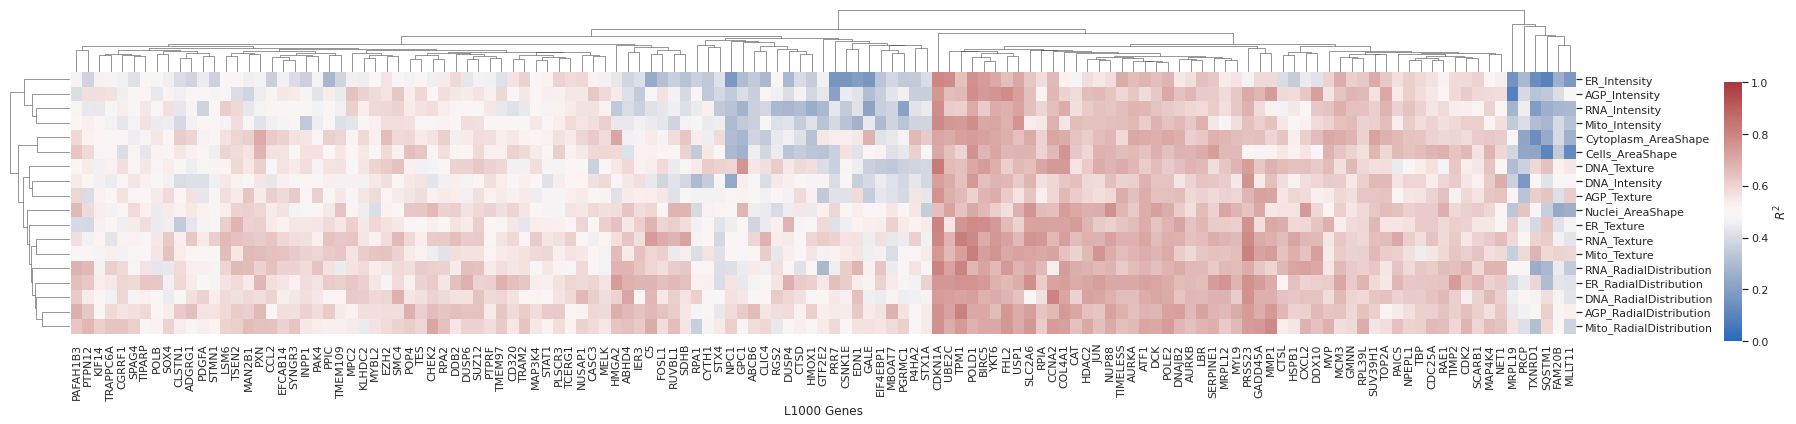

In [17]:
# %matplotlib notebook
which_ds_model='LUAD-9-MLP-keras-ht'
# which_ds_model='LUAD-9-lasso-ht'

dfcats=saved_scores[which_ds_model].rename(columns={'Unnamed: 0':'ID'})
dfcats=dfcats[dfcats.columns[~dfcats.isna().any()].tolist()]
dfcats2,_=rename_affyprobe_to_genename(dfcats.set_index('ID').T,dfcats.ID.tolist(),'../idmap.xlsx')
dfcats=dfcats2.T#.reset_index()
dfcats.index.names = ['L1000 Genes']
topGenes_df2=dfcats[dfcats.max(axis=1)>0.6]
# cmap="coolwarm"
clustergrid=sns.clustermap(topGenes_df2.T,xticklabels=1,yticklabels=1,figsize=(24, 6),cmap="vlag",\
vmin=0, vmax=1,cbar_kws={'label': '$R^2$'},cbar_pos=(1, .2, .01, .6),dendrogram_ratio=(0.04,0.2))

if 0:
    # clustergrid.savefig(results_dir+'/SingleGenePred_cpCategoryMap/CatMap-'+which_ds_model+'.png', format='png',dpi=200)
    saveAsNewSheetToExistingFile(source_data_add,clustergrid.data2d,'fig2d')

## Modality Integration

In [ ]:
# filename=results_dir+'/MoAprediction/pred_moa.xlsx'
filename=results_dir+'/MoAprediction/pred_moa_CDRP.xlsx'
saved_scores_cdrpbio=pd.read_excel(filename, sheet_name=None)
saved_scores_cdrpbio.keys()

In [ ]:
filename=results_dir+'/MoAprediction/pred_moa_LINCS.xlsx'
saved_scores_lincs=pd.read_excel(filename, sheet_name=None)
saved_scores_lincs.keys()

In [ ]:
# from sklearn.metrics import f1_score
# res_df=pd.DataFrame(columns=['Modality','Model'])
# DS='LINCS'
# scores_mlp=saved_scores['fC-'+DS+'-nvs-filt-preds-lr-ht']
# mofa_scores_2add=saved_scores['mofa-100fac'+DS+'-nvs-filt-preds-lr-ht']

In [ ]:
# mofa_scores_2add

In [ ]:
from sklearn.metrics import f1_score
res_df_lincs=pd.DataFrame(columns=['Modality','Model'])
DS='LINCS'
scores_mlp=saved_scores_lincs['fC-'+DS+'-nvs-filt-preds-mlp-ht-3']
# mofa_scores_2add=saved_scores['mofa-100fac'+DS+'-nvs-filt-preds-mlp-ht-2']
# scores_mlp['mofa']=mofa_scores_2add['mofa']


for dd in ['CP', 'GE', 'Early Fusion', 'Late Fusion','RGCCA_EarlyFusion']:
    scor_vals=scores_mlp[dd].apply(lambda x: int(eval(x)[0]) if type(x)==str else x)    
    f1=f1_score(scor_vals,scores_mlp.Metadata_moa_num.values, average='macro')
    temp_df = pd.DataFrame(data={'Modality': [dd], 'Model': ['MLP'],'F1-score':[f1*100]})
    res_df_lincs=res_df_lincs.append(temp_df)
    
    
scores_mlp=saved_scores_lincs['fC-'+DS+'-nvs-filt-preds-lr-ht-3']
# mofa_scores_2add=saved_scores['mofa-100fac'+DS+'-nvs-filt-preds-lr-ht-2']
# scores_mlp['mofa']=mofa_scores_2add['mofa']

# for dd in ['CP', 'GE', 'Early Fusion', 'Late Fusion','RGCCA_CP','RGCCA_GE','RGCCA_EarlyFusion']:
for dd in ['CP', 'GE', 'Early Fusion', 'Late Fusion','RGCCA_EarlyFusion']:
    scor_vals=scores_mlp[dd].apply(lambda x: int(eval(x)[0]) if type(x)==str else x)    
    f1=f1_score(scores_mlp.Metadata_moa_num.values,scor_vals, average='macro')
    temp_df = pd.DataFrame(data={'Modality': [dd], 'Model': ['Logistic R'],'F1-score':[f1*100]})
    res_df_lincs=res_df_lincs.append(temp_df)
    
    
#########################################################
res_df_cdrpbio=pd.DataFrame(columns=['Modality','Model'])
DS='CDRP-bio'
scores_mlp=saved_scores_cdrpbio['fC-'+DS+'-nvs-filt-preds-mlp-ht-5']
# mofa_scores_2add=saved_scores['mofa-100fac'+DS+'-nvs-filt-preds-mlp-ht-2']
# scores_mlp['mofa']=mofa_scores_2add['mofa']


for dd in ['CP', 'GE', 'Early Fusion', 'Late Fusion','RGCCA_EarlyFusion']:
    scor_vals=scores_mlp[dd].apply(lambda x: int(eval(x)[0]) if type(x)==str else x)    
    f1=f1_score(scor_vals,scores_mlp.Metadata_moa_num.values, average='macro')
    temp_df = pd.DataFrame(data={'Modality': [dd], 'Model': ['MLP'],'F1-score':[f1*100]})
    res_df_cdrpbio=res_df_cdrpbio.append(temp_df)
    
    
scores_mlp=saved_scores_cdrpbio['fC-'+DS+'-nvs-filt-preds-lr-ht-5']
# mofa_scores_2add=saved_scores['mofa-100fac'+DS+'-nvs-filt-preds-lr-ht-2']
# scores_mlp['mofa']=mofa_scores_2add['mofa']

# for dd in ['CP', 'GE', 'Early Fusion', 'Late Fusion','RGCCA_CP','RGCCA_GE','RGCCA_EarlyFusion']:
for dd in ['CP', 'GE', 'Early Fusion', 'Late Fusion','RGCCA_EarlyFusion']:
    scor_vals=scores_mlp[dd].apply(lambda x: int(eval(x)[0]) if type(x)==str else x)    
    f1=f1_score(scores_mlp.Metadata_moa_num.values,scor_vals, average='macro')
    temp_df = pd.DataFrame(data={'Modality': [dd], 'Model': ['Logistic R'],'F1-score':[f1*100]})
    res_df_cdrpbio=res_df_cdrpbio.append(temp_df)


In [ ]:
import matplotlib.style as style
style.use('seaborn-colorblind')
sns.set_context("paper",font_scale = 1.5, rc={"font.size":4,"axes.titlesize":14,"axes.labelsize":15})
res_df1=res_df_lincs[res_df_lincs['Modality']!='Early Fusion']
res_df2=res_df_lincs[res_df_lincs['Modality']!='Late Fusion']

sns.set_style("whitegrid")
fig,axes=plt.subplots(1,2,figsize=(9,5),sharey=True)
sns.barplot(x="Model", y="F1-score", hue="Modality", data=res_df_cdrpbio,ax=axes[0])#,**kwargs)
# plt.legend(loc='top', borderaxespad=0)
# plt.legend(bbox_to_anchor=(0.27, 1), loc='upper left', borderaxespad=0)
axes[0].legend([],[], frameon=False)
plt.tight_layout()
# axes[0].set_ylim(0,60)
axes[0].set_title('CDRP-bio')
n_classes=16;
axes[0].axhline(y=(100/n_classes),linestyle='--',color='r',linewidth=2);

###################
sns.barplot(x="Model", y="F1-score", hue="Modality", data=res_df_lincs,ax=axes[1])#,**kwargs)
# plt.legend(loc='top', borderaxespad=0)
plt.legend(bbox_to_anchor=(1, 1), loc='upper left', borderaxespad=0)
plt.tight_layout()
axes[1].set_ylim(0,70)
axes[1].set_title('LINCS')
axes[1].set(ylabel=None)
n_classes=57;
axes[1].axhline(y=(100/n_classes),linestyle='--',color='r',linewidth=2);

plt.tight_layout()
# for a in ax.patches:
#     a.set_width(0.15)
# plt.savefig('moa_class_bar.png')

In [ ]:
import matplotlib.style as style
style.use('seaborn-colorblind')
sns.set_context("paper",font_scale = 1.5, rc={"font.size":4,"axes.titlesize":14,"axes.labelsize":15})
res_df1=res_df_lincs[res_df_lincs['Modality']!='Early Fusion']
res_df2=res_df_lincs[res_df_lincs['Modality']!='Late Fusion']

sns.set_style("whitegrid")
fig,axes=plt.subplots(1,2,figsize=(9,5),sharey=True)
sns.barplot(x="Model", y="F1-score", hue="Modality", data=res_df_cdrpbio,ax=axes[0])#,**kwargs)
# plt.legend(loc='top', borderaxespad=0)
# plt.legend(bbox_to_anchor=(0.27, 1), loc='upper left', borderaxespad=0)
axes[0].legend([],[], frameon=False)
plt.tight_layout()
# axes[0].set_ylim(0,60)
axes[0].set_title('CDRP-bio')
n_classes=16;
axes[0].axhline(y=(100/n_classes),linestyle='--',color='r',linewidth=2);

###################
sns.barplot(x="Model", y="F1-score", hue="Modality", data=res_df_lincs,ax=axes[1])#,**kwargs)
# plt.legend(loc='top', borderaxespad=0)
plt.legend(bbox_to_anchor=(1, 1), loc='upper left', borderaxespad=0)
plt.tight_layout()
axes[1].set_ylim(0,70)
axes[1].set_title('LINCS')
axes[1].set(ylabel=None)
n_classes=57;
axes[1].axhline(y=(100/n_classes),linestyle='--',color='r',linewidth=2);

plt.tight_layout()
# for a in ax.patches:
#     a.set_width(0.15)
# plt.savefig('moa_class_bar.png')

In [ ]:
import matplotlib.style as style
style.use('seaborn-colorblind')
sns.set_context("paper",font_scale = 1.5, rc={"font.size":4,"axes.titlesize":14,"axes.labelsize":15})
res_df1=res_df_lincs[res_df_lincs['Modality']!='Early Fusion']
res_df2=res_df_lincs[res_df_lincs['Modality']!='Late Fusion']

sns.set_style("whitegrid")
fig,axes=plt.subplots(1,2,figsize=(9,5),sharey=True)
sns.barplot(x="Model", y="F1-score", hue="Modality", data=res_df_cdrpbio,ax=axes[0])#,**kwargs)
# plt.legend(loc='top', borderaxespad=0)
# plt.legend(bbox_to_anchor=(0.27, 1), loc='upper left', borderaxespad=0)
axes[0].legend([],[], frameon=False)
plt.tight_layout()
# axes[0].set_ylim(0,60)
axes[0].set_title('CDRP-bio')
n_classes=16;
axes[0].axhline(y=(100/n_classes),linestyle='--',color='r',linewidth=2);

###################
sns.barplot(x="Model", y="F1-score", hue="Modality", data=res_df_lincs,ax=axes[1])#,**kwargs)
# plt.legend(loc='top', borderaxespad=0)
plt.legend(bbox_to_anchor=(1, 1), loc='upper left', borderaxespad=0)
plt.tight_layout()
axes[1].set_ylim(0,70)
axes[1].set_title('LINCS')
axes[1].set(ylabel=None)
n_classes=57;
axes[1].axhline(y=(100/n_classes),linestyle='--',color='r',linewidth=2);

plt.tight_layout()
# for a in ax.patches:
#     a.set_width(0.15)
# plt.savefig('moa_class_bar.png')

In [ ]:
import matplotlib.style as style
style.use('seaborn-colorblind')
sns.set_context("paper",font_scale = 1.5, rc={"font.size":4,"axes.titlesize":14,"axes.labelsize":15})
res_df1=res_df[res_df['Modality']!='Early Fusion']
res_df2=res_df[res_df['Modality']!='Late Fusion']

sns.set_style("whitegrid")
plt.figure(figsize=(4,5))
ax = sns.barplot(x="Model", y="F1-score", hue="Modality", data=res_df)#,**kwargs)
# ax = sns.barplot(x="Model", y="F1-score", hue="Modality", data=res_df2)
# ax.legend(ncol = 1, loc = 'upper center')
# plt.legend(loc='top', borderaxespad=0)
plt.legend(bbox_to_anchor=(0.27, 1), loc='upper left', borderaxespad=0)
plt.tight_layout()
ax.set_ylim(0,100)
ax.set_title(DS)
n_classes=57;
ax.axhline(y=(100/n_classes),linestyle=':',color='r');

for a in ax.patches:
    a.set_width(0.15)
# plt.savefig('moa_class_bar.eps')

In [ ]:
import matplotlib.style as style
style.use('seaborn-colorblind')
sns.set_context("paper",font_scale = 1.5, rc={"font.size":4,"axes.titlesize":14,"axes.labelsize":15})
res_df1=res_df[res_df['Modality']!='Early Fusion']
res_df2=res_df[res_df['Modality']!='Late Fusion']

sns.set_style("whitegrid")
plt.figure(figsize=(4,5))
ax = sns.barplot(x="Model", y="F1-score", hue="Modality", data=res_df)#,**kwargs)
# ax = sns.barplot(x="Model", y="F1-score", hue="Modality", data=res_df2)
# ax.legend(ncol = 1, loc = 'upper center')
# plt.legend(loc='top', borderaxespad=0)
plt.legend(bbox_to_anchor=(0.27, 1), loc='upper left', borderaxespad=0)
plt.tight_layout()
ax.set_ylim(0,100)
ax.set_title(DS)
n_classes=57;
ax.axhline(y=(100/n_classes),linestyle=':',color='r');

for a in ax.patches:
    a.set_width(0.15)
# plt.savefig('moa_class_bar.eps')

## Modality Integration - k-fold
- Figure 4b

In [ ]:
# filename=results_dir+'/MoAprediction/pred_moa.xlsx'
filename=results_dir+'/MoAprediction/pred_moa_CDRP.xlsx'
saved_scores_cdrpbio=pd.read_excel(filename, sheet_name=None)
saved_scores_cdrpbio.keys()

filename=results_dir+'/MoAprediction/pred_moa_LINCS.xlsx'
saved_scores_lincs=pd.read_excel(filename, sheet_name=None)
saved_scores_lincs.keys()

In [ ]:
from sklearn.metrics import f1_score
res_df_lincs=pd.DataFrame(columns=['Modality','Model'])
DS='LINCS'
scores_mlp=saved_scores_lincs['fC-'+DS+'-nvs-filt-preds-mlp-ht-sgkf-1']
# mofa_scores_2add=saved_scores['mofa-100fac'+DS+'-nvs-filt-preds-mlp-ht-2']
# scores_mlp['mofa']=mofa_scores_2add['mofa']

folds=scores_mlp['Fold'].unique().tolist()
for f in folds:
    scores_mlp_f=scores_mlp[scores_mlp['Fold']==f];
    for dd in ['CP', 'GE', 'Early Fusion', 'Late Fusion','RGCCA_EarlyFusion']:
        scor_vals=scores_mlp_f[dd].apply(lambda x: int(eval(x)[0]) if type(x)==str else x)    
        f1=f1_score(scor_vals,scores_mlp_f.Metadata_moa_num.values, average='macro')
        temp_df = pd.DataFrame(data={'Modality': [dd], 'Model': ['MLP'],'F1-score':[f1]})
        res_df_lincs=res_df_lincs.append(temp_df)
    
    
scores_mlp=saved_scores_lincs['fC-'+DS+'-nvs-filt-preds-lr-ht-sgkf-1']
# mofa_scores_2add=saved_scores['mofa-100fac'+DS+'-nvs-filt-preds-lr-ht-2']
# scores_mlp['mofa']=mofa_scores_2add['mofa']
folds=scores_mlp['Fold'].unique().tolist()
for f in folds:
    scores_mlp_f=scores_mlp[scores_mlp['Fold']==f];
    # for dd in ['CP', 'GE', 'Early Fusion', 'Late Fusion','RGCCA_CP','RGCCA_GE','RGCCA_EarlyFusion']:
    for dd in ['CP', 'GE', 'Early Fusion', 'Late Fusion','RGCCA_EarlyFusion']:
        scor_vals=scores_mlp_f[dd].apply(lambda x: int(eval(x)[0]) if type(x)==str else x)    
        f1=f1_score(scores_mlp_f.Metadata_moa_num.values,scor_vals, average='macro')
        temp_df = pd.DataFrame(data={'Modality': [dd], 'Model': ['Logistic R'],'F1-score':[f1]})
        res_df_lincs=res_df_lincs.append(temp_df)
    
    
#########################################################
res_df_cdrpbio=pd.DataFrame(columns=['Modality','Model'])
DS='CDRP-bio'
scores_mlp=saved_scores_cdrpbio['fC-'+DS+'-nvs-filt-preds-mlp-ht-sgkf-1']
# mofa_scores_2add=saved_scores['mofa-100fac'+DS+'-nvs-filt-preds-mlp-ht-2']
# scores_mlp['mofa']=mofa_scores_2add['mofa']

folds=scores_mlp['Fold'].unique().tolist()
for f in folds:
    scores_mlp_f=scores_mlp[scores_mlp['Fold']==f];
    for dd in ['CP', 'GE', 'Early Fusion', 'Late Fusion','RGCCA_EarlyFusion']:
        scor_vals=scores_mlp_f[dd].apply(lambda x: int(eval(x)[0]) if type(x)==str else x)    

        f1=f1_score(scor_vals,scores_mlp_f.Metadata_moa_num.values, average='macro')
        temp_df = pd.DataFrame(data={'Modality': [dd], 'Model': ['MLP'],'F1-score':[f1]})
        res_df_cdrpbio=res_df_cdrpbio.append(temp_df)
    
    
scores_mlp=saved_scores_cdrpbio['fC-'+DS+'-nvs-filt-preds-lr-ht-sgkf-1']
# mofa_scores_2add=saved_scores['mofa-100fac'+DS+'-nvs-filt-preds-lr-ht-2']
# scores_mlp['mofa']=mofa_scores_2add['mofa']

folds=scores_mlp['Fold'].unique().tolist()
for f in folds:
    scores_mlp_f=scores_mlp[scores_mlp['Fold']==f];
    # for dd in ['CP', 'GE', 'Early Fusion', 'Late Fusion','RGCCA_CP','RGCCA_GE','RGCCA_EarlyFusion']:
    for dd in ['CP', 'GE', 'Early Fusion', 'Late Fusion','RGCCA_EarlyFusion']:
        scor_vals=scores_mlp_f[dd].apply(lambda x: int(eval(x)[0]) if type(x)==str else x)    
        f1=f1_score(scores_mlp_f.Metadata_moa_num.values,scor_vals, average='macro')
        temp_df = pd.DataFrame(data={'Modality': [dd], 'Model': ['Logistic R'],'F1-score':[f1]})
        res_df_cdrpbio=res_df_cdrpbio.append(temp_df)


In [ ]:
# res_df_cdrpbio

In [ ]:
#* Statistical tests for differences in the features across groups
from scipy import stats
all_t = list()
all_p = list()
for m in ['Logistic R','MLP']:
    sub_df = res_df_cdrpbio[res_df_cdrpbio['Model'] == m]
    g1 = sub_df[sub_df['Modality']=='CP']['F1-score'].values
    for di in ['GE','Early Fusion', 'Late Fusion','RGCCA_EarlyFusion']:
        g2 = sub_df[sub_df['Modality']==di]['F1-score'].values
        t, p = stats.ttest_ind(g1, g2)
        all_t.append(t)
        all_p.append(p)
all_p

In [ ]:
#* Statistical tests for differences in the features across groups
from scipy import stats
all_t = list()
all_p = list()
for m in ['Logistic R','MLP']:
    sub_df = res_df_lincs[res_df_lincs['Model'] == m]
    g1 = sub_df[sub_df['Modality']=='CP']['F1-score'].values
    for di in ['GE','Early Fusion', 'Late Fusion','RGCCA_EarlyFusion']:
        g2 = sub_df[sub_df['Modality']==di]['F1-score'].values
        t, p = stats.ttest_ind(g1, g2)
        all_t.append(t)
        all_p.append(p)
all_p

In [ ]:
# res_df_cdrpbio
import matplotlib.style as style
style.use('seaborn-colorblind')
sns.set_context("paper",font_scale = 1.5, rc={"font.size":4,"axes.titlesize":14,"axes.labelsize":15})
res_df1=res_df_lincs[res_df_lincs['Modality']!='Early Fusion']
res_df2=res_df_lincs[res_df_lincs['Modality']!='Late Fusion']

# sns.set_style("whitegrid")
fig,axes=plt.subplots(1,2,figsize=(10,5),sharey=True)
# sns.barplot(x="Model", y="F1-score", hue="Modality", data=res_df_cdrpbio,ax=axes[0])#,**kwargs)
sns.boxplot(x="Model", y="F1-score", hue="Modality", data=res_df_cdrpbio,ax=axes[0])#,**kwargs)
# plt.legend(loc='top', borderaxespad=0)
# plt.legend(bbox_to_anchor=(0.27, 1), loc='upper left', borderaxespad=0)
axes[0].legend([],[], frameon=False)
plt.tight_layout()
axes[0].set_ylim(0,50)
axes[0].set_title('CDRP-bio')
n_classes=16;
axes[0].axhline(y=(1/n_classes),linestyle='--',color='r',linewidth=2);

###################
# sns.barplot(x="Model", y="F1-score", hue="Modality", data=res_df_lincs,ax=axes[1])#,**kwargs)
sns.boxplot(x="Model", y="F1-score", hue="Modality", data=res_df_lincs,ax=axes[1])#,**kwargs)
# plt.legend(loc='top', borderaxespad=0)
plt.legend(bbox_to_anchor=(1.1, 1), loc='upper left', borderaxespad=0)
plt.tight_layout()
axes[1].set_ylim(0,0.5)
axes[1].set_title('LINCS')
axes[1].set(ylabel=None)
n_classes=57;
axes[1].axhline(y=(1/n_classes),linestyle='--',color='r',linewidth=2);

plt.tight_layout()
# for a in ax.patches:
#     a.set_width(0.15)
# plt.savefig('moa_class_bar.png')

In [ ]:
res_df_lincs.groupby(['Modality','Model']).size()

In [ ]:
if 1:
    saveAsNewSheetToExistingFile(source_data_add,res_df_lincs,'fig4b')

    # fig.tight_layout()
    fig.savefig('fig4b.pdf',papertype='letter',dpi=500)

## Supplementary E - Top 50 CP using MLP
- Supplementary Figure 3

In [ ]:
DataPredResults.Model.unique()

In [ ]:
datasets=['TAORF', 'CDRP-bio']


models=["MLP"]
f='-filt';#'-filt'
DataPredResults_appC=DataPredResults.copy()
fig, axes = plt.subplots(len(datasets),1,figsize=(10,15))
sns.set_context("paper")
sns.set_style("whitegrid")
# sns.rcParams['patch.force_edgecolor'] = True
# for d in range(5):#(len(datasets)):
for d in range(len(datasets)):
    for m in range(len(models)):
        dataset_meth_dists=DataPredResults_appC[(DataPredResults_appC['Dataset']==datasets[d]) &\
                                                    (DataPredResults_appC['Model']==models[m])]
#         kjhlhjl
#         CP-Features
        sorted_gene_mean_scores=dataset_meth_dists[dataset_meth_dists['d']=='n-folds'].groupby(['CP-Features','d']).median().reset_index().sort_values(by=['pred score'],ascending=False)
        top_lmGenes=sorted_gene_mean_scores['CP-Features'].tolist()[0:50]
        dataset_meth_dists_top_50=dataset_meth_dists[dataset_meth_dists['CP-Features'].isin(top_lmGenes)]
        
#         f, axes = plt.subplots(figsize=(15,4))
        axes[d].set_title("Dataset: "+datasets[d])
        sns.boxplot(x="CP-Features", y="pred score",hue="d", data=dataset_meth_dists_top_50,ax=axes[d],\
                    order=top_lmGenes,palette=my_pal,hue_order=['random','n-folds'])
        # ax = sns.violinplot(x="lmGens", y="pred score", hue="d",data=tips2, palette="muted", split=True)
        axes[d].set_xticklabels(axes[d].get_xticklabels(),rotation=90,fontsize=10);
        axes[d].set_ylim(-1, 1)
        
fig.tight_layout()
fig.savefig('supp_e1.pdf',papertype='letter',dpi=500)
# fig.savefig('appendix_C1.eps')

datasets=['LINCS', 'LUAD']
fig, axes = plt.subplots(len(datasets),1,figsize=(10,15))
sns.set_context("paper")
sns.set_style("whitegrid")
# sns.rcParams['patch.force_edgecolor'] = True
# for d in range(5):#(len(datasets)):
for d in range(len(datasets)):
    for m in range(len(models)):
        dataset_meth_dists=DataPredResults_appC[(DataPredResults_appC['Dataset']==datasets[d]) &\
                                                    (DataPredResults_appC['Model']==models[m])]
#         kjhlhjl
#         CP-Features
        sorted_gene_mean_scores=dataset_meth_dists[dataset_meth_dists['d']=='n-folds'].groupby(['CP-Features','d']).median().reset_index().sort_values(by=['pred score'],ascending=False)
        top_lmGenes=sorted_gene_mean_scores['CP-Features'].tolist()[0:50]
        dataset_meth_dists_top_50=dataset_meth_dists[dataset_meth_dists['CP-Features'].isin(top_lmGenes)]
        
#         f, axes = plt.subplots(figsize=(15,4))
        axes[d].set_title("Dataset: "+datasets[d])
        sns.boxplot(x="CP-Features", y="pred score",hue="d", data=dataset_meth_dists_top_50,ax=axes[d],\
                    order=top_lmGenes,palette=my_pal,hue_order=['random','n-folds'])
        # ax = sns.violinplot(x="lmGens", y="pred score", hue="d",data=tips2, palette="muted", split=True)
        axes[d].set_xticklabels(axes[d].get_xticklabels(),rotation=90,fontsize=10);
        axes[d].set_ylim(-1, 1)
        
fig.tight_layout()
# fig.savefig('appendix_C2.eps')

fig.savefig('supp_e2.pdf',papertype='letter',dpi=500)

## MoA Cluster retrieval 
- Figure 4a

In [ ]:
%matplotlib notebook
# res_fig9="~/workspace_rosetta/workspace/software/2021_Haghighi_NeurIPS_Dataset_submitted/results_CP_GE/57/JI.txt"
res_fig9="~/workspace_rosetta/workspace/software/2021_Haghighi_NeurIPS_Dataset_submitted/JDR/results_CP_GE_cdrpbio/16/JI.txt"
res_fig9_df=pd.read_csv(res_fig9, sep="\t")
res_fig9_df=res_fig9_df.rename(columns={"concat":'Early Fusion'})
# res_fig9_df.boxplot()

f, axes = plt.subplots(1, 2, sharey=True,figsize=(7,5))
sns.boxplot(x="variable", y="value", data=pd.melt(res_fig9_df),order=['CP', 'GE', 'Early Fusion', 'RGCCA', 'MCIA', 'MOFA', 'iCluster', 'intNMF',
       'JIVE', 'scikit-fusion'],ax=axes[0]);
axes[0].set_xticklabels(axes[0].get_xticklabels(),rotation=90,size=13)
axes[0].set_ylabel("Jaccard Index (JI)", fontsize=13)
axes[0].set_ylim([0,.4]);axes[0].set_title('CDRP-bio');
res_fig9_df['Dataset']='CDRP-bio'


res_fig9="~/workspace_rosetta/workspace/software/2021_Haghighi_NeurIPS_Dataset_submitted/JDR/results_CP_GE_lincs/57/JI.txt"
res_fig9_df_2=pd.read_csv(res_fig9, sep="\t")
res_fig9_df_2=res_fig9_df_2.rename(columns={"concat":'Early Fusion'})
# res_fig9_df_2.boxplot()

sns.boxplot(x="variable", y="value", data=pd.melt(res_fig9_df_2),order=['CP', 'GE', 'Early Fusion', 'RGCCA', 'MCIA', 'MOFA', 'iCluster', 'intNMF',
       'JIVE', 'scikit-fusion'],ax=axes[1]);
axes[1].set_xticklabels(axes[1].get_xticklabels(),rotation=90,size=13)
axes[1].set(ylabel=None)
# axes[1].set_ylabel("Jaccard Index (JI)", fontsize=11)
axes[1].set_ylim([0,.5]);axes[1].set_title('LINCS');
res_fig9_df_2['Dataset']='LINCS'

plt.tight_layout()

if 0:
    saveAsNewSheetToExistingFile(source_data_add,pd.concat([res_fig9_df,res_fig9_df_2]),'fig4a')

    # fig.tight_layout()
    f.savefig('fig4a.pdf',papertype='letter',dpi=500)

In [ ]:
# res_fig9_df

In [ ]:
#* Statistical tests for differences in the features across groups
from scipy import stats
all_t = list()
all_p = list()

g1 = res_fig9_df['CP'].values
for di in res_fig9_df.columns:
    g2 = res_fig9_df[di].values
    t, p = stats.ttest_ind(g1, g2)
    all_t.append(t)
    all_p.append(p)
all_p

In [ ]:
# report_clss4=res_fig9_df[['CP','GE','RGCCA']]
# # report_clss4.index=report_clss3['MoA']
# ax = report_clss4.plot.bar(rot=90,figsize=(10,6))
# plt.title('MoA class specific F1-scores')
# ax.set_ylim([0,1])